### 0. Initialisation

In [18]:
save_path = "/Users/aljoscha/Downloads/locustVR_data"

import os,json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('default')
import importlib

from LocustVR_data_analysis import utils_local

importlib.reload(utils_local)
from LocustVR_data_analysis.utils_local import align_and_flip_heading, reindex_t_by_state_transition, convert_trial_label, plt_density, align_trajectories, compute_directness_and_direction, access_utilities

### 2. Load data

In [19]:
df = pd.read_pickle(os.path.join(save_path, 'locustvr_data.pkl'))

In [20]:
grouped = df.groupby("animal_id")["trial_id"].agg(["max", "nunique"])
print(grouped)

           max  nunique
animal_id              
0           31       32
1           29       30
2           31       32
3           14       15
4           31       32
5           34       35
6           35       36
7           18       19
8           26       27
9           25       26
10          21       22
11          25       26
12          30       31
13           6        7
14          34       35
15          26       27
16          32       33
17          28       29
18          33       34
19          27       28
20          21       22
21          30       31


In [5]:
print(df)

                  X           Y   heading     ts  trial_id  state_type  \
0          0.001724   -0.000008  2.978185  -7211         0           0   
1         -0.008445    0.001091  2.978185  -7210         0           0   
2         -0.018577    0.002156  2.978185  -7209         0           0   
3         -0.028663    0.003190  2.978185  -7208         0           0   
4         -0.038699    0.004192  2.970926  -7207         0           0   
...             ...         ...       ...    ...       ...         ...   
7853448 -160.593521 -118.996429  1.157819   6955        30           1   
7853449 -160.593476 -118.996619  1.190118   6956        30           1   
7853450 -160.593417 -118.996833  1.190118   6957        30           1   
7853451 -160.593342 -118.997071  1.120649   6958        30           1   
7853452 -160.593253 -118.997336  1.120649   6959        30           1   

         animal_id  heading_rel  heading_rel_flip  constant_distance  \
0                0    -0.147917        

### 3. Visualisation

In [6]:
save_plots = False
angle_version = ["heading_rel", "heading_rel_flip"]
select = ["data", "angle", "angular_velocity"]

t_max = df['ts'].max()
sec = t_max / 60
limits = [[-3000 / sec, 8000 / sec], [-180, 180]]

plot_type = ["hist", "kde"] # Options: hist, kde

angle_bins = np.linspace(-np.pi, np.pi, 360)  # 1° bins
time_ts = [-2000, 0, 500, 1000, 6000, 9494]
critical_time1 = time_ts / sec
time_seconds = np.array([2, 10])
critical_time2 = time_seconds * sec  # Convert seconds to the same scale as 'ts'

position_version1 = ["X_flip", "Y_flip"]
position_version2 = ["X_aligned", "Y_aligned"]
# position_version = [position_version1, position_version2]
position_version = [position_version2]

def default_style(x_label, y_label):
    plt.xlim(limits[0][0], limits[0][1])
    plt.ylim(limits[1][0], limits[1][1])
    plt.grid(False)
    plt.box(True)
    plt.xlabel(x_label, fontsize=16)
    plt.ylabel(y_label, fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.tight_layout()

def generate_plot_type(plot_type):
    if plot_type == "hist":
        plt_hist = True
        plt_kde = False
    elif plot_type == "kde":
        plt_kde = True
        plt_hist = False
    else:
        raise ValueError("plot_type must be 'hist' or 'kde'")
    return plt_hist, plt_kde

def generate_time_windows(critical_time):
    time_windows = {}
    for i in range(len(critical_time)-1):
        row = {f"t1 ({critical_time[i]:.1f} to {critical_time[i+1]:.1f})": (critical_time[i], critical_time[i+1]),}
        time_windows.update(row)
    return time_windows



#### 3.1 Angle over time

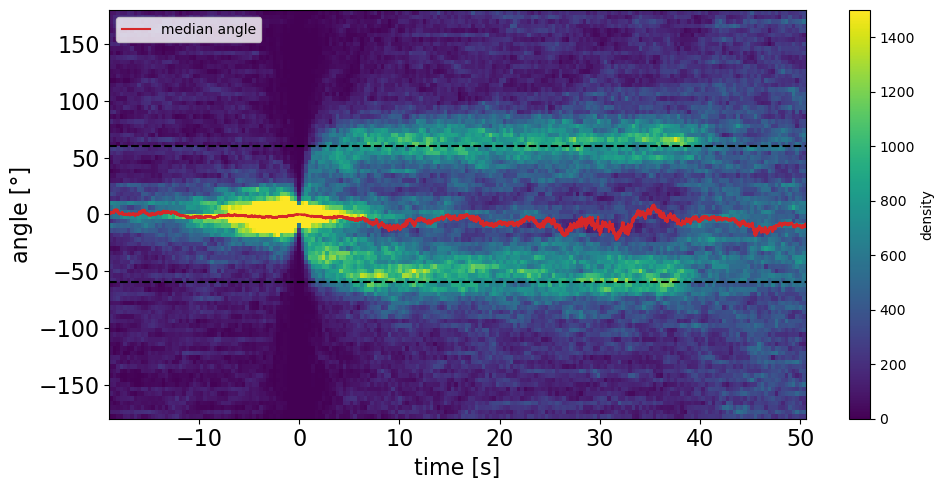

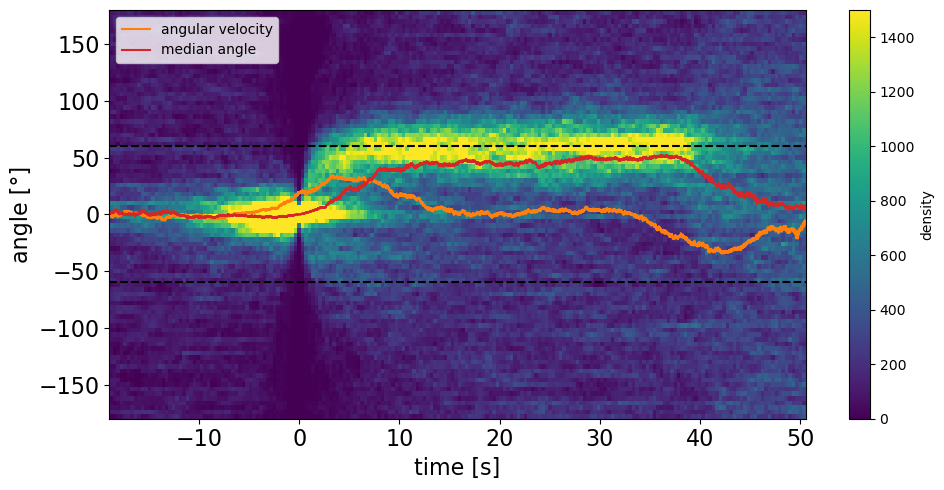

In [17]:
angle_version = ["heading_rel", "heading_rel_flip"]
for version in angle_version:
    fig, ax = plt.subplots(figsize=(10, 5))
    if "data" in select:
        # Prepare data
        x = df['ts'] / sec
        y = np.degrees(df[version])

        # Heatmap with log color normalization for better contrast
        heatmap = ax.hist2d(
            x, y,
            bins=[200, 90],  # time x angle resolution
            range=[[limits[0][0], limits[0][1]], [limits[1][0], limits[1][1]]],
            cmap='viridis',
            # norm=LogNorm(vmin=1, vmax=1000),
            density=False,
            vmax=1500
        )

        cbar = fig.colorbar(heatmap[3], ax=ax)
        cbar.set_label("density")

    # Median angle
    df_mean = df.groupby('ts', as_index=False)[version].median()

    # Angular velocity
    df_median = df.groupby('ts', as_index=False)[version].median()
    df_median = df_median.sort_values('ts')
    df_median['heading_smooth'] = df_median[version].rolling(window=1500, center=True).mean()
    df_median['angular_velocity'] = df_median['heading_smooth'].diff() / df_median['ts'].diff()
    df_median = df_median.dropna(subset=['angular_velocity'])
    if version == "heading_rel_flip":
        if "angular_velocity" in select:
            ax.plot(df_median['ts'] / sec, np.degrees(df_median['angular_velocity'] * 1200), color='C1', label='angular velocity')
    if "angle" in select:
        ax.plot(df_mean['ts'] / sec, np.degrees(df_mean[version]), color='C3', label='median angle')

    # ±60° reference
    ax.axhline(60, color='black', linestyle='--')
    ax.axhline(-60, color='black', linestyle='--')

    # Labels, limits, legend
    default_style(x_label="time [s]", y_label="angle [°]")
    ax.set_xlim(limits[0])
    ax.set_ylim(limits[1])
    ax.legend(loc='upper left')

    # plt.savefig(os.path.join(save_path, 'angle_vs_time_heatmap.png'), format='png', dpi=500)
    plt.show()

#### 3.2 Desity of angles (for time bins)

##### 3.2.1 Histogram

heading_rel


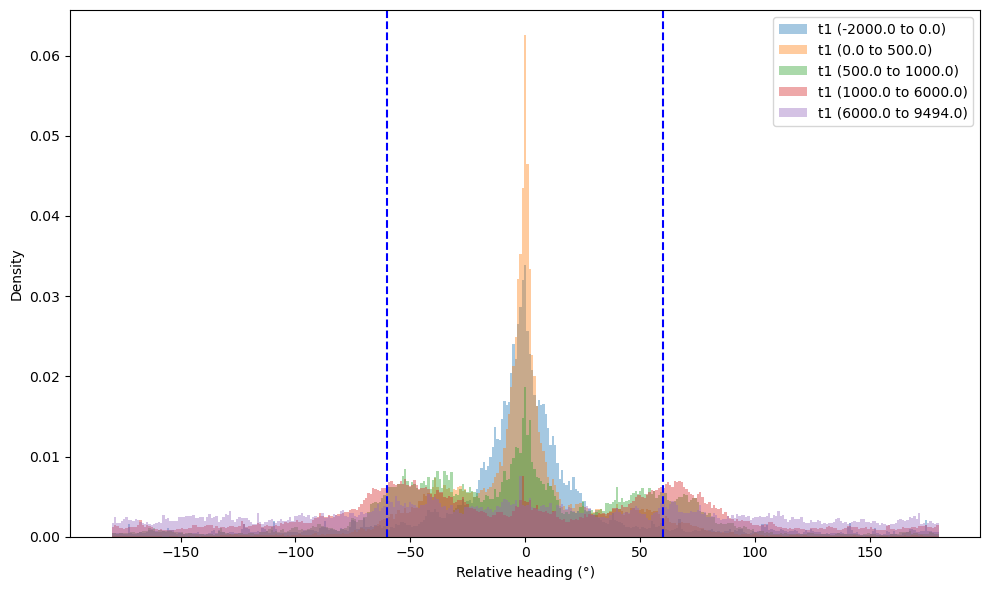

heading_rel_flip


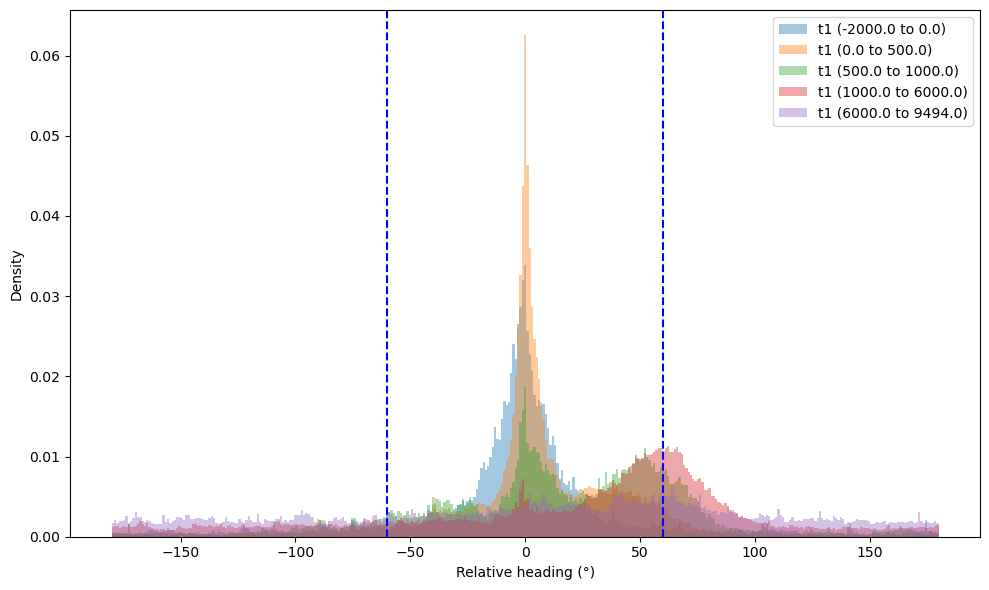

heading_rel


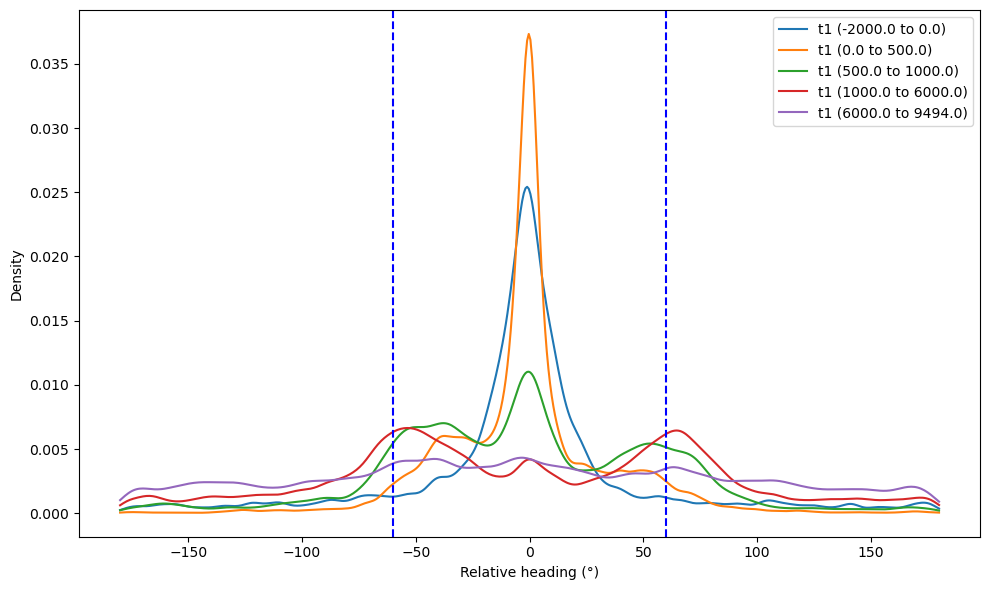

heading_rel_flip


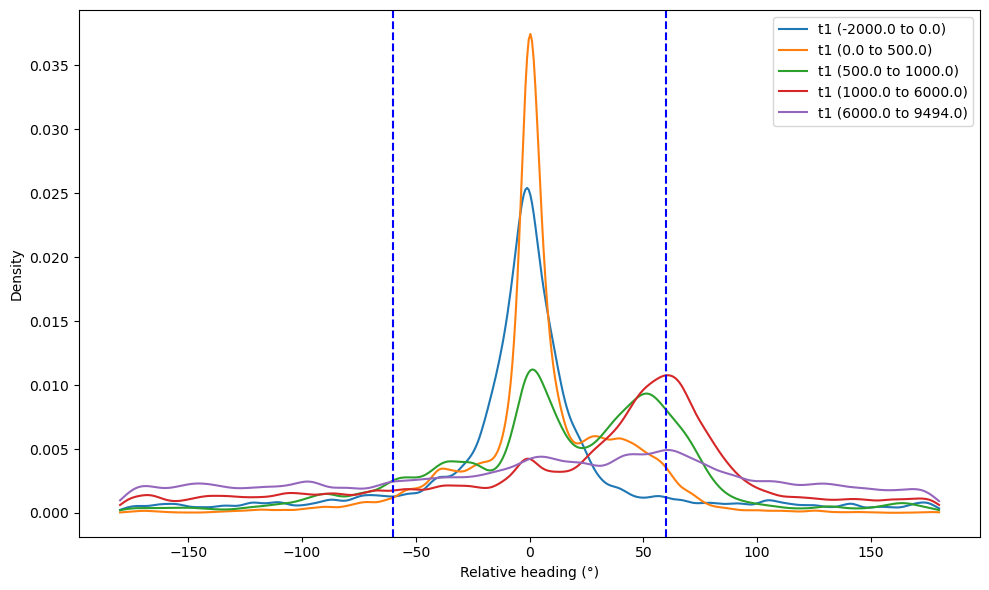

In [29]:
time_windows = generate_time_windows(time_ts)
for type in plot_type:
    plt_hist, plt_kde = generate_plot_type(type)
    for version in angle_version:
        print(version)
        plt.figure(figsize=(10, 6))
        plt_density(df, version, time_windows, angle_bins, plt_hist=plt_hist, plt_kde=plt_kde, label2=time_windows.keys())
        # plt.savefig(os.path.join(save_path, f'{type}_{version}.png'), format='png', dpi=500)
        plt.show()

In [46]:
time_windows = generate_time_windows(time_ts)
print(time_windows)

{'t1 (-2000.0 to 0.0)': (-2000, 0), 't1 (0.0 to 500.0)': (0, 500), 't1 (500.0 to 1000.0)': (500, 1000), 't1 (1000.0 to 6000.0)': (1000, 6000), 't1 (6000.0 to 9494.0)': (6000, 9494)}


Plot type: kde | Angle version: heading_rel_flip
  Plotting for animal: 0


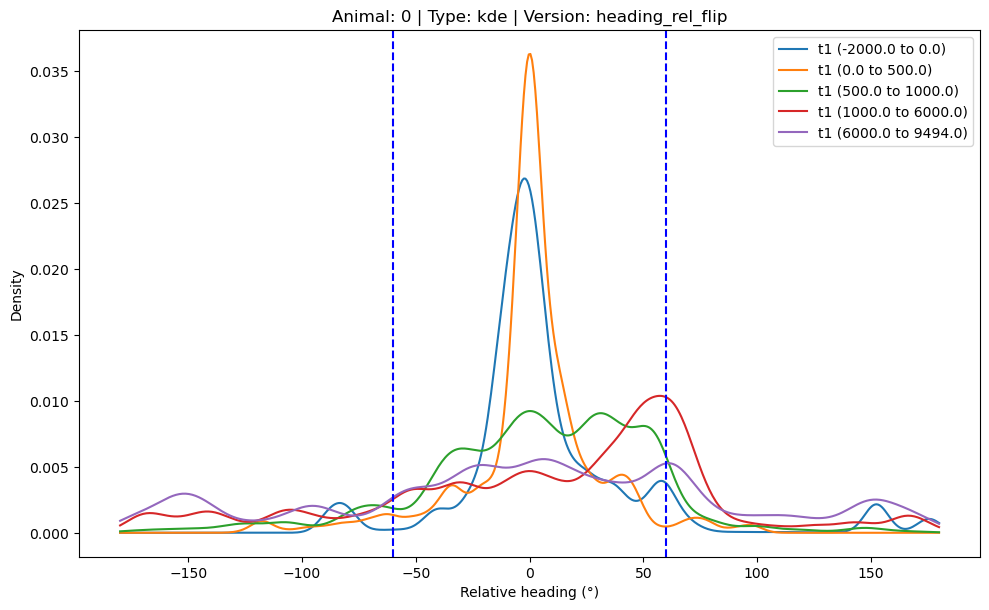

  Plotting for animal: 1


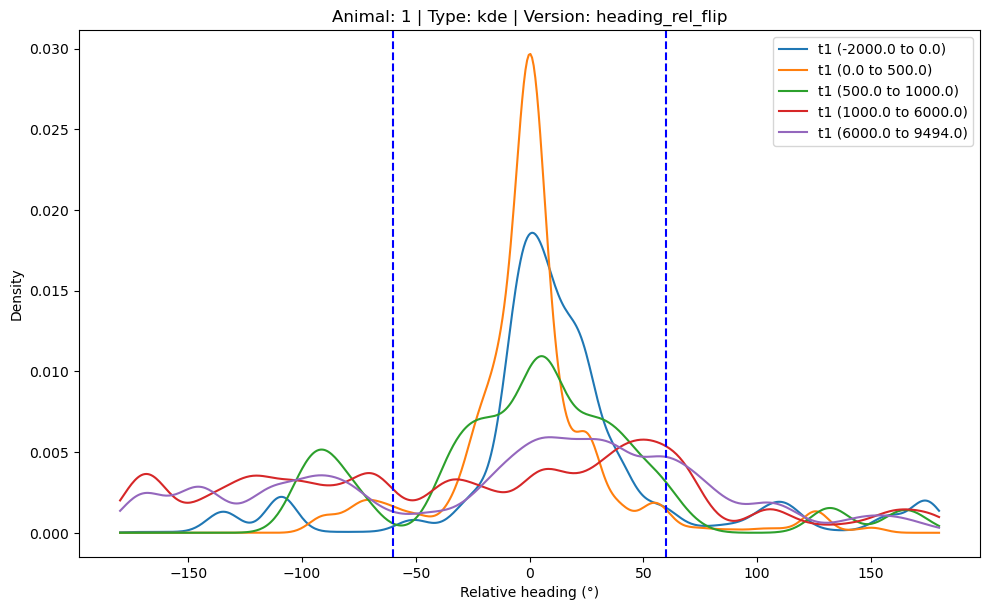

  Plotting for animal: 2


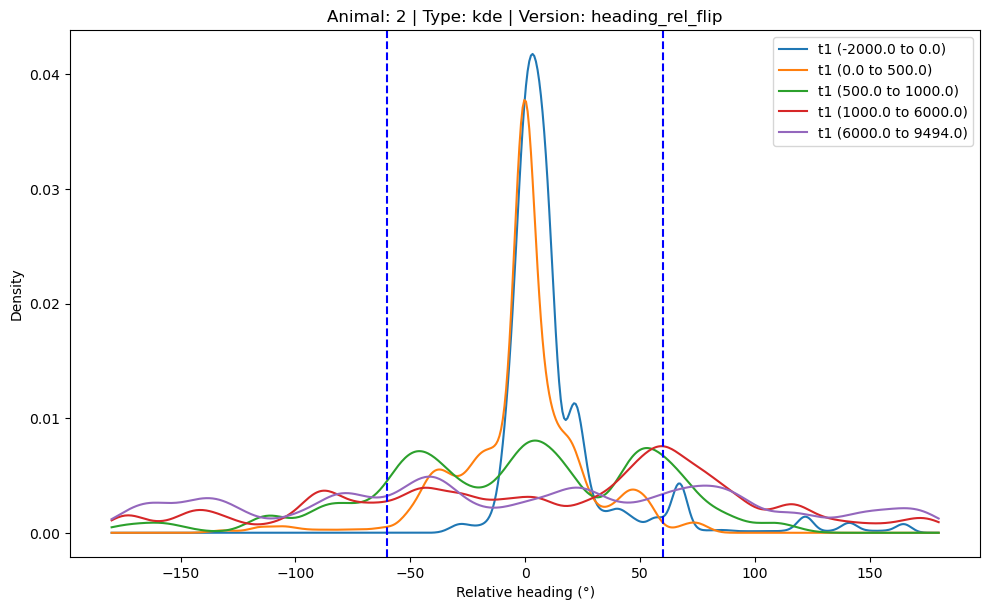

  Plotting for animal: 3


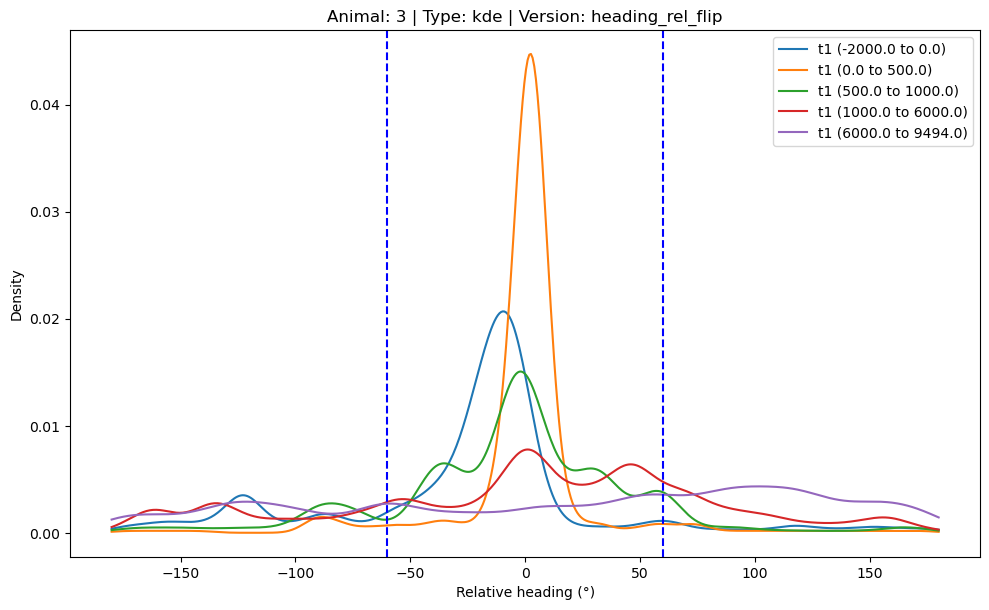

  Plotting for animal: 4


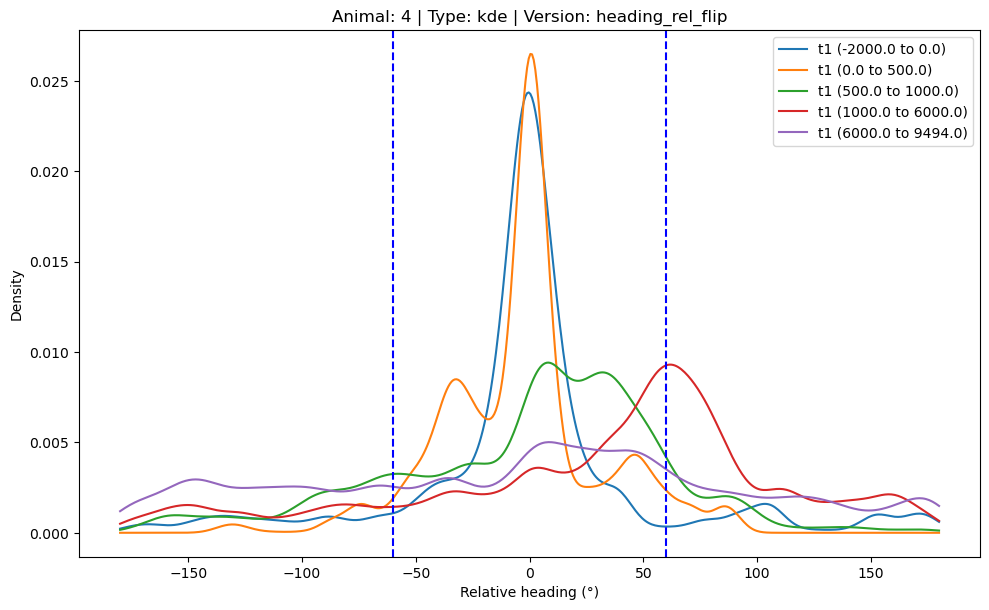

  Plotting for animal: 5


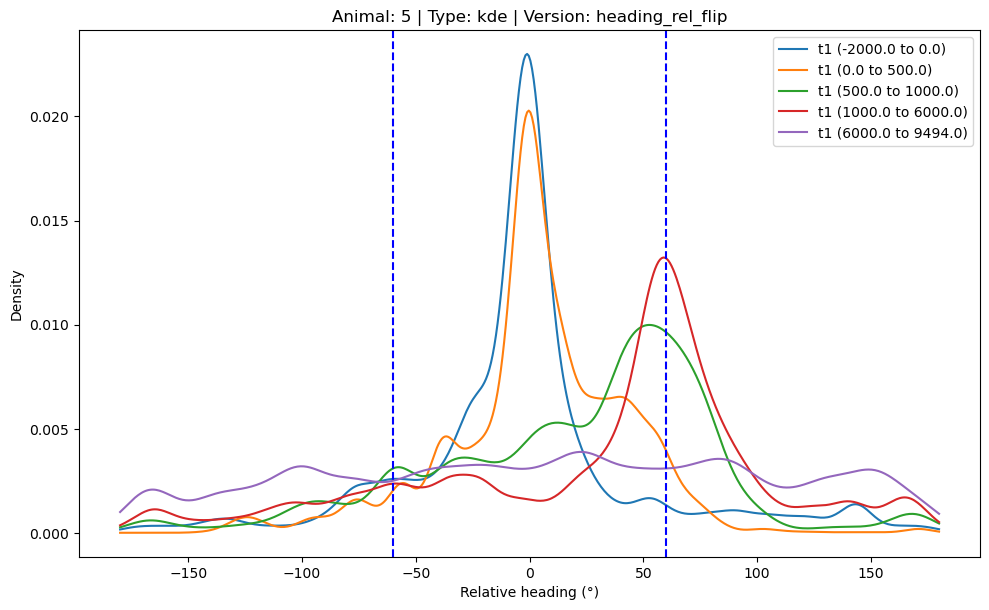

  Plotting for animal: 6


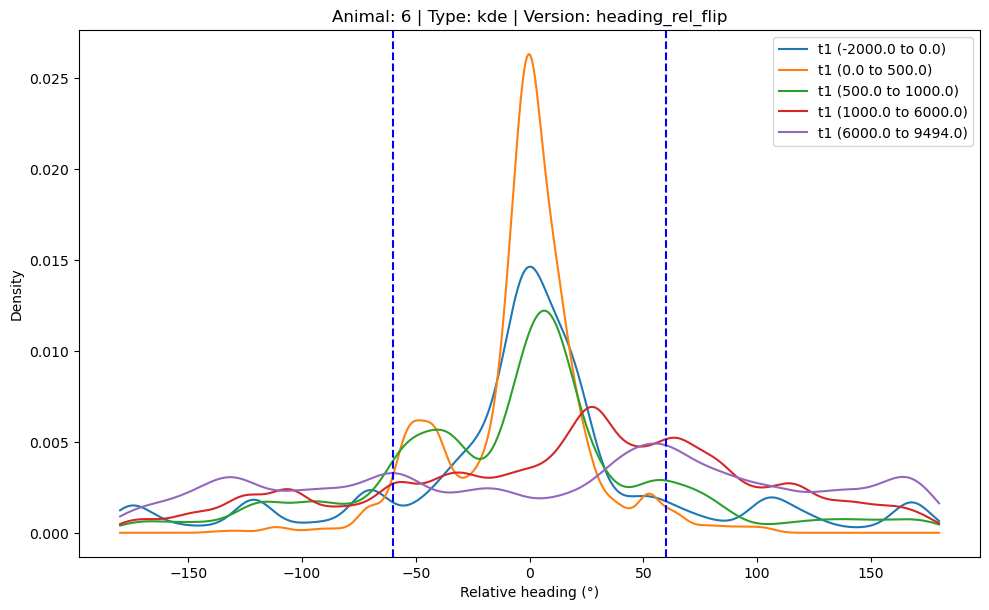

  Plotting for animal: 7


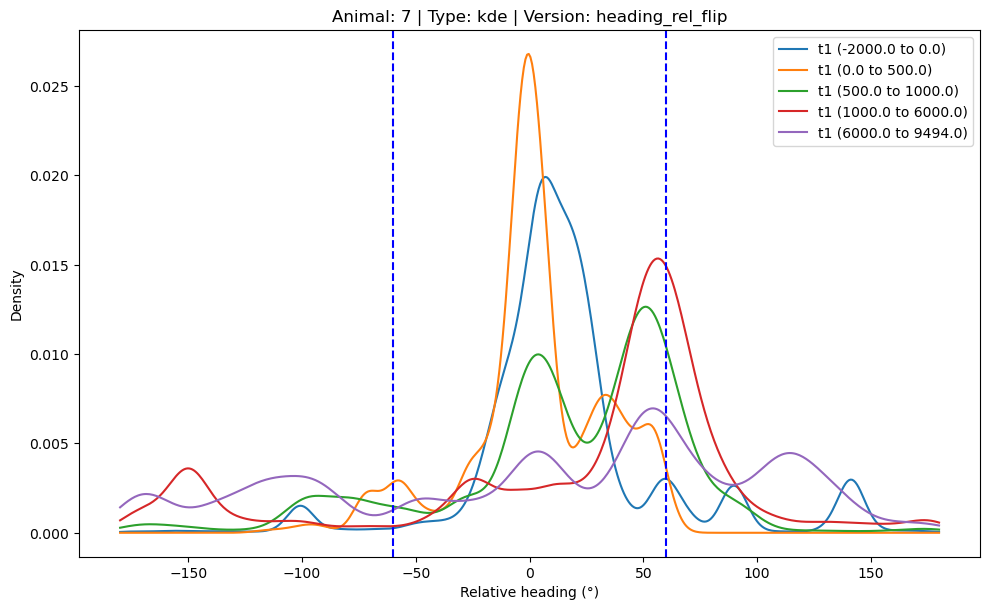

  Plotting for animal: 8


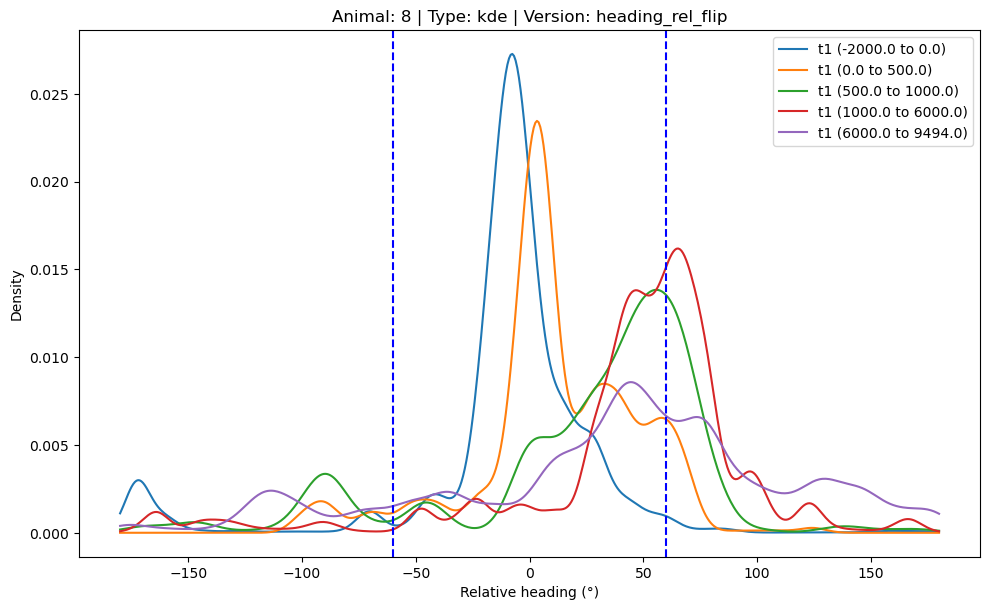

  Plotting for animal: 9


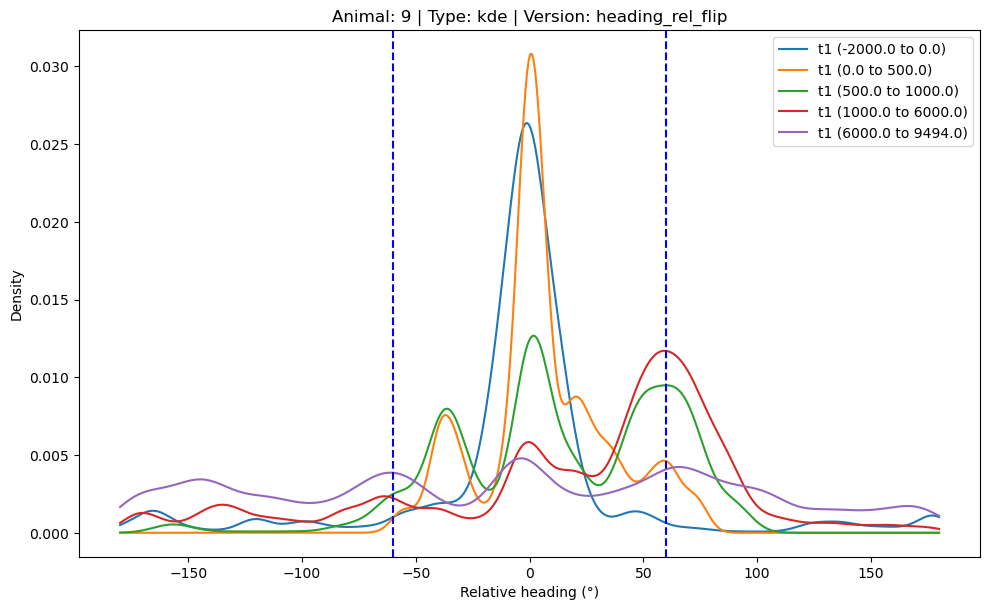

  Plotting for animal: 10


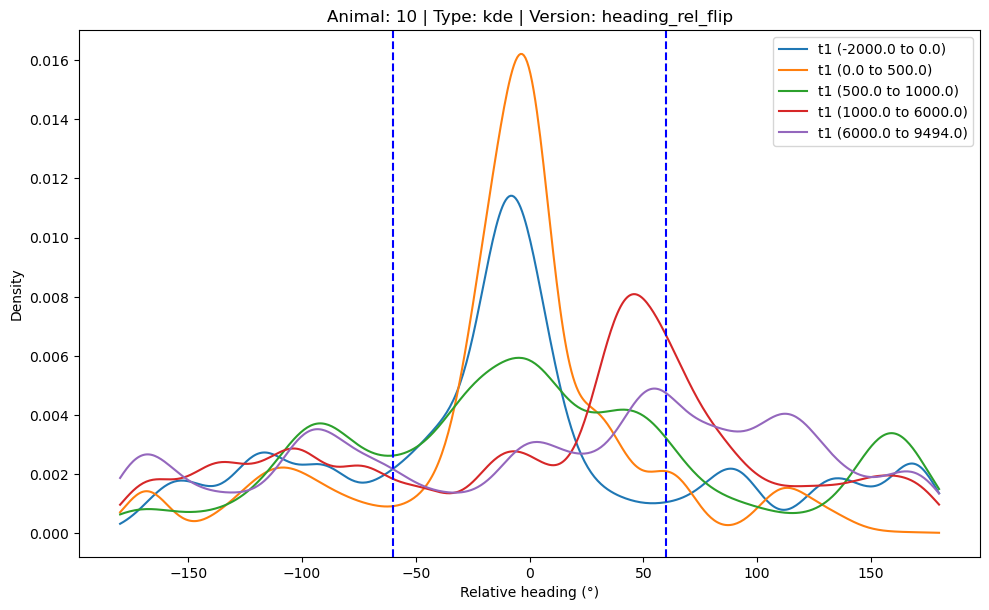

  Plotting for animal: 11


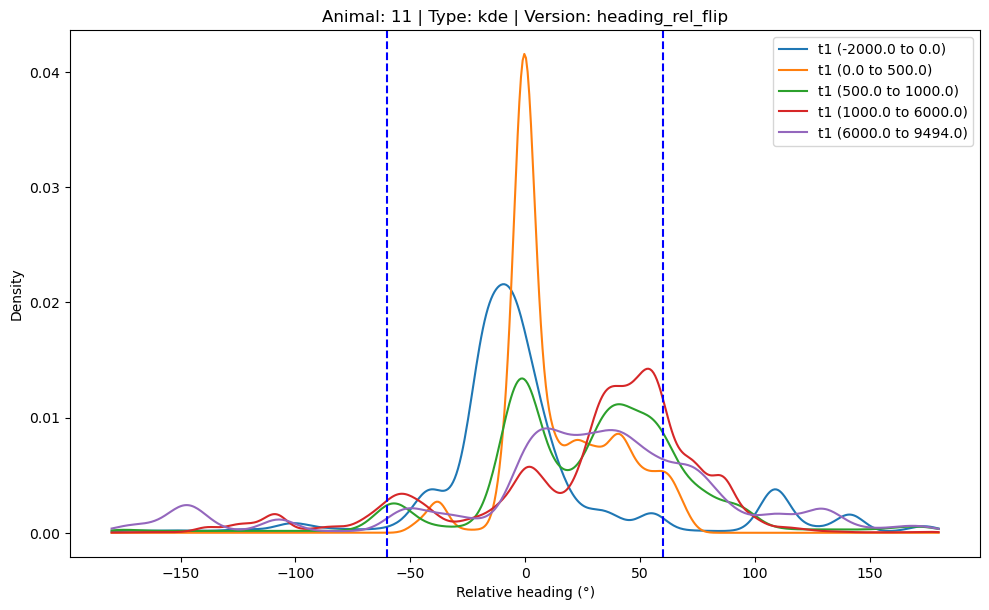

  Plotting for animal: 12


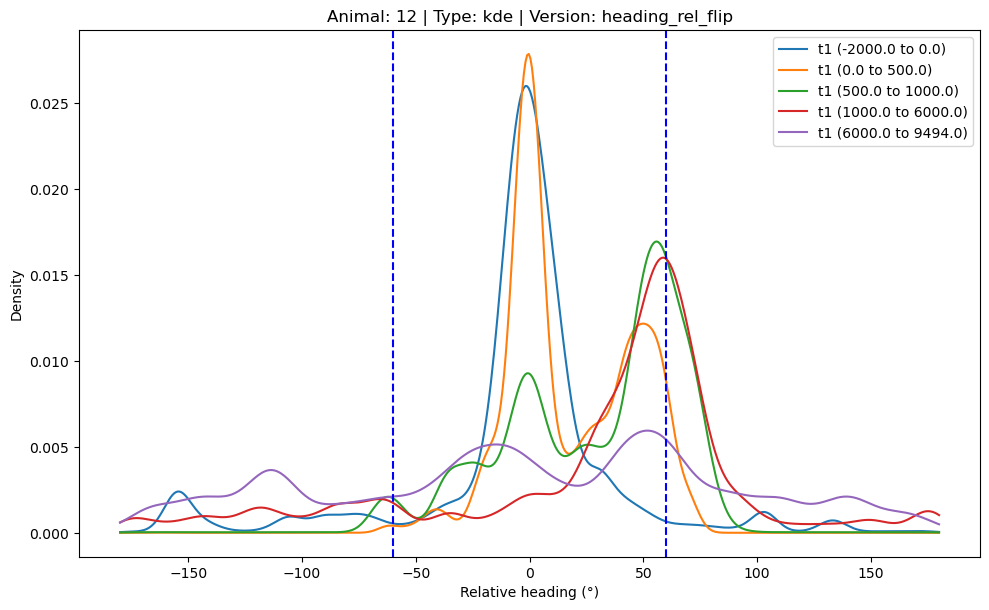

  Plotting for animal: 13


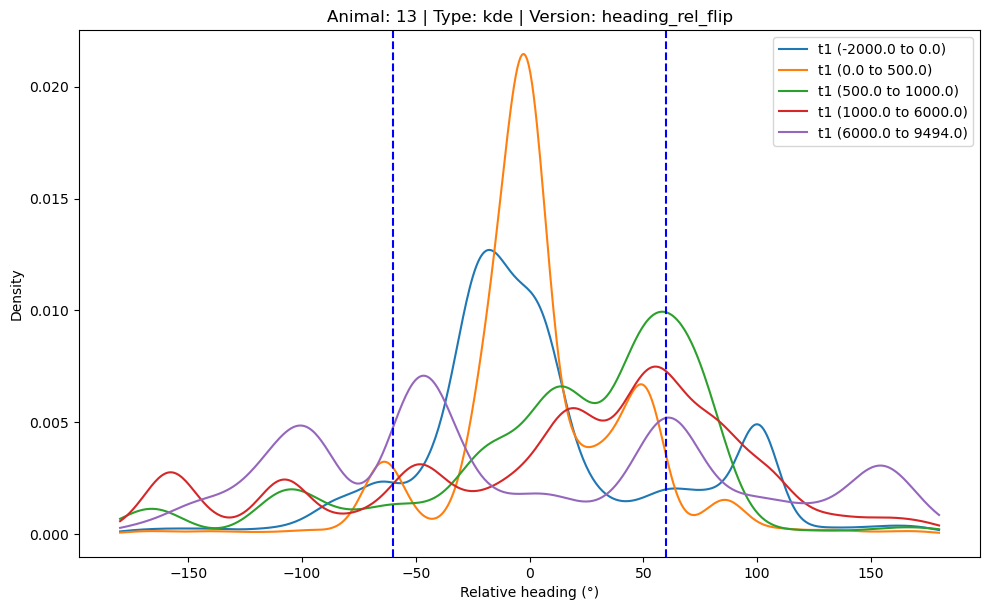

  Plotting for animal: 14


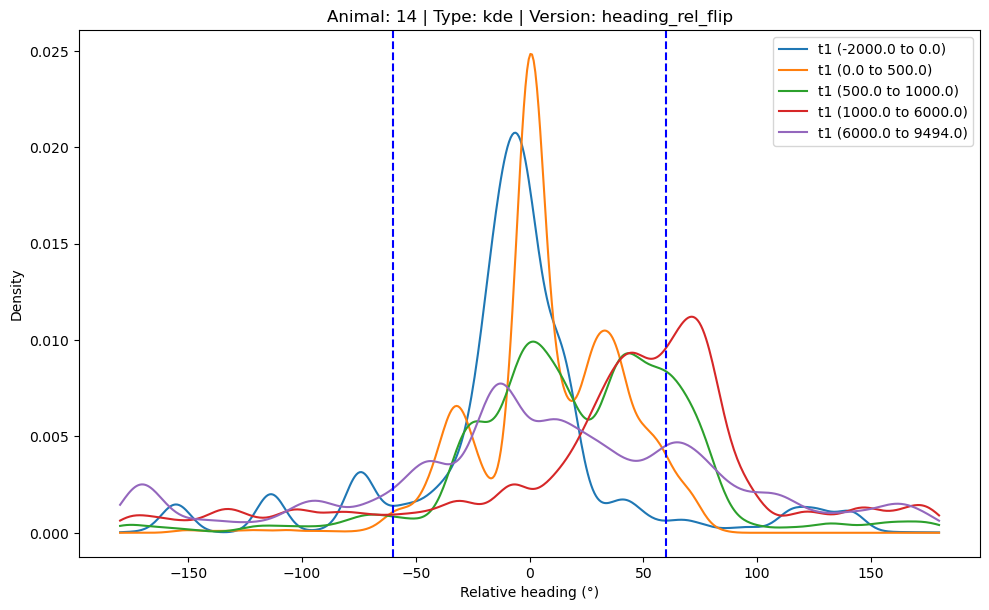

  Plotting for animal: 15


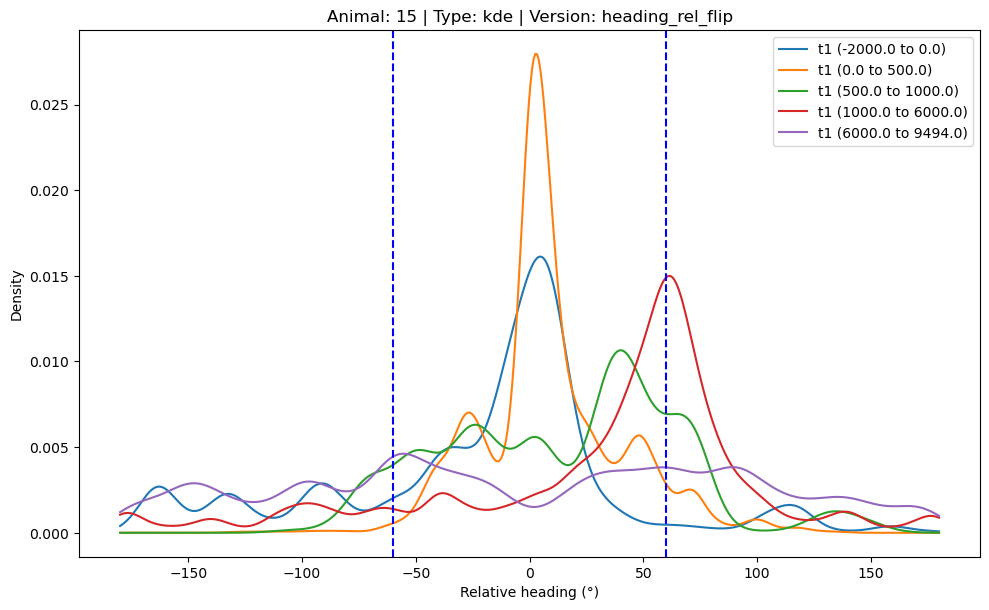

  Plotting for animal: 16


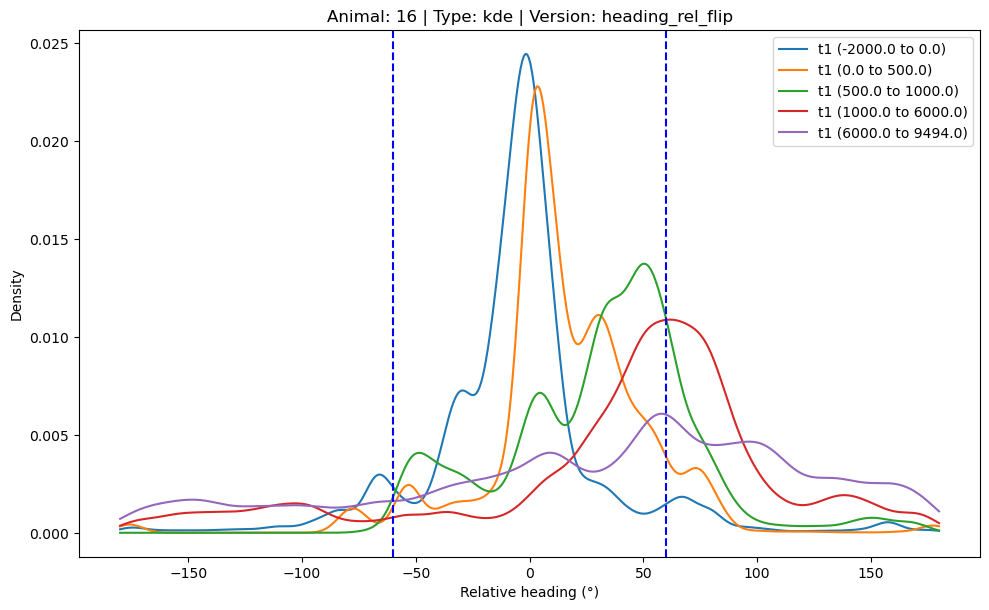

  Plotting for animal: 17


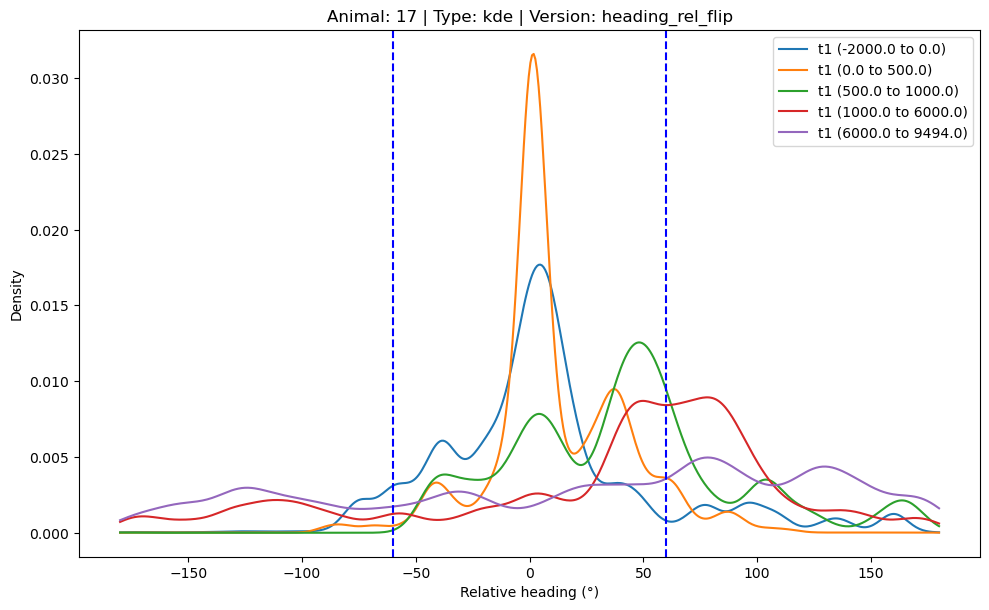

  Plotting for animal: 18


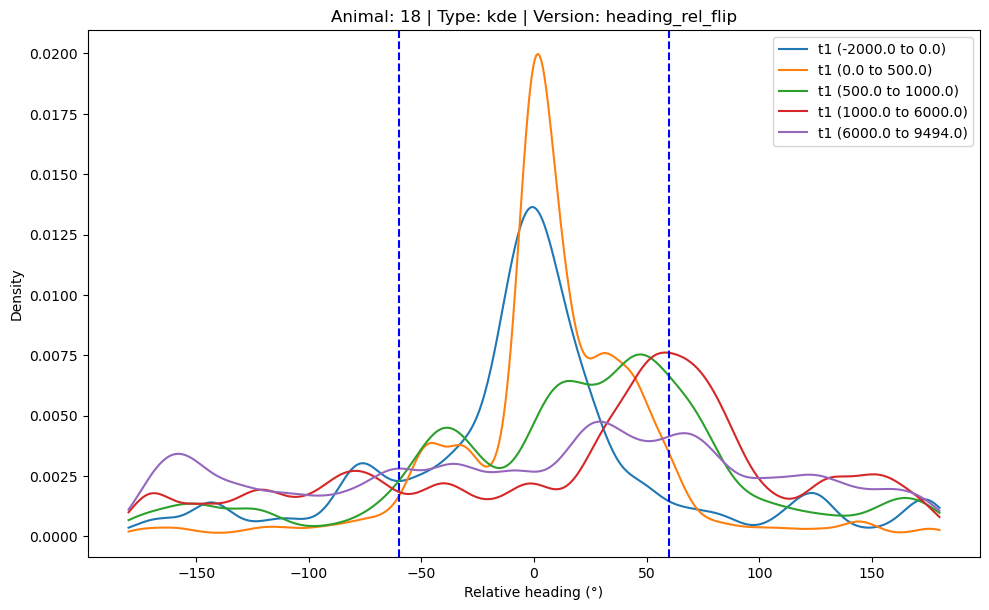

  Plotting for animal: 19


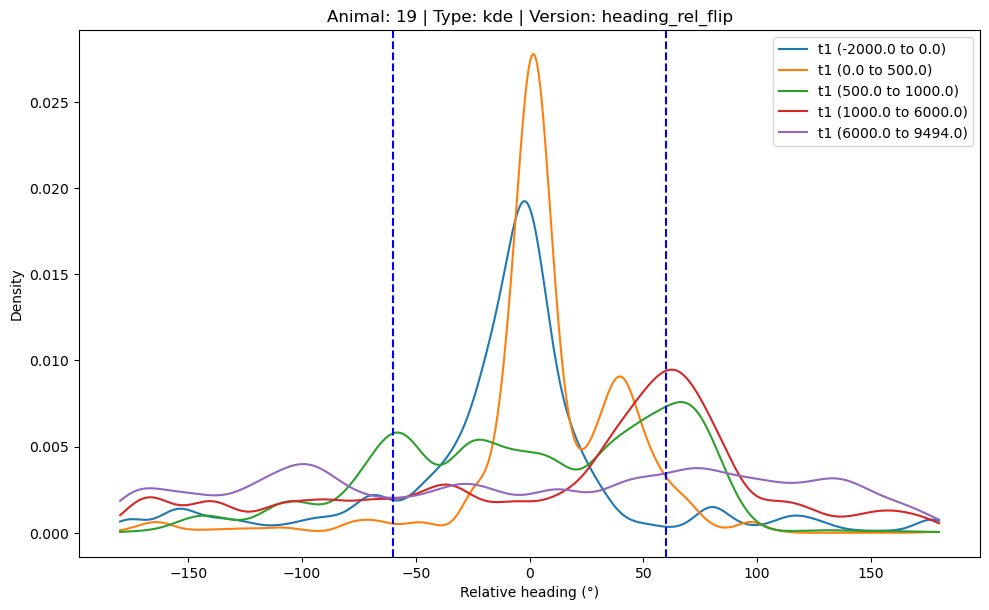

  Plotting for animal: 20


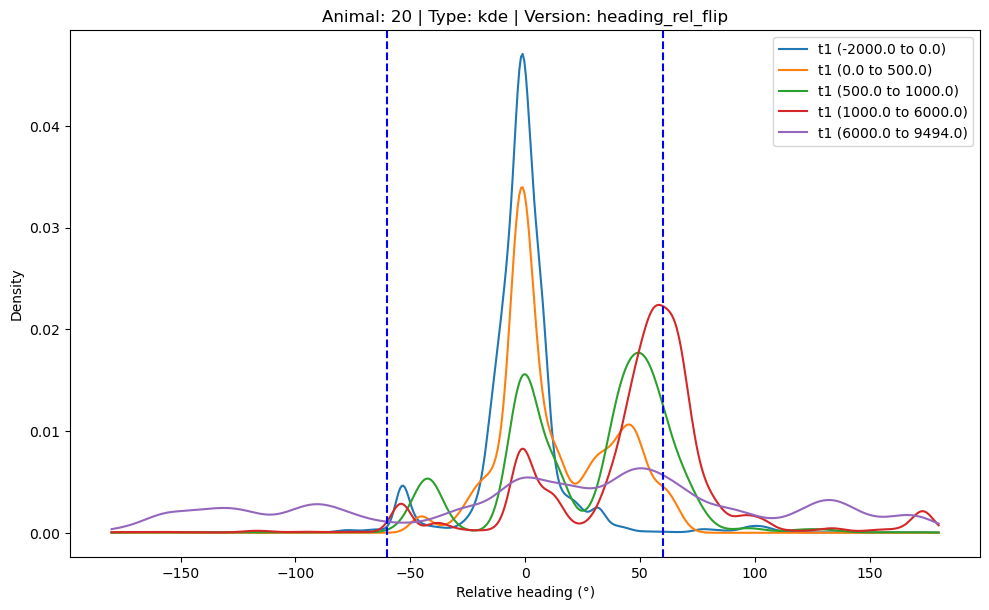

  Plotting for animal: 21


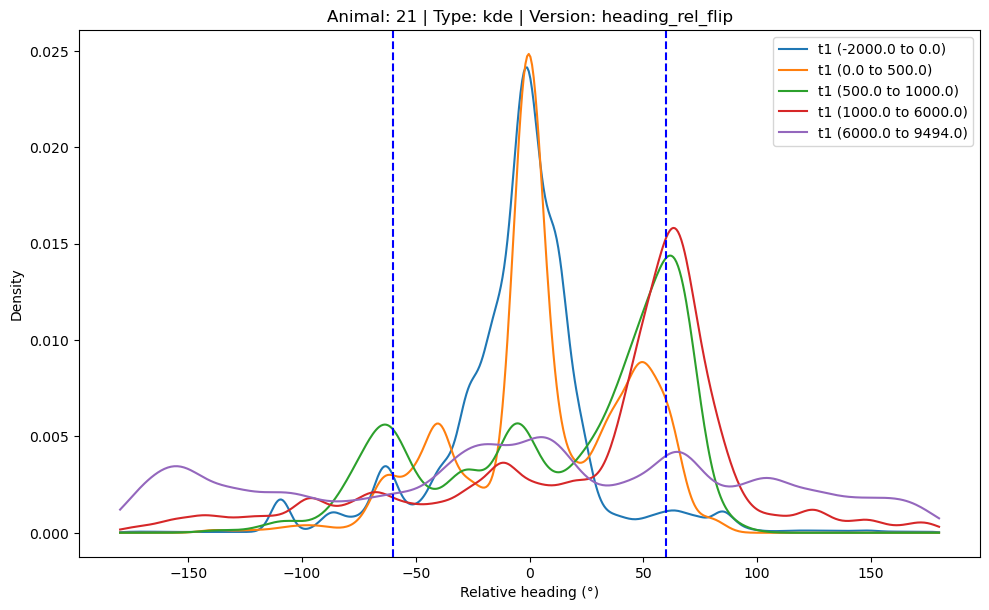

In [47]:
plot_type = ["kde"]
angle_version = ["heading_rel_flip"]

for type in plot_type:
    plt_hist, plt_kde = generate_plot_type(type)

    for version in angle_version:
        print(f"Plot type: {type} | Angle version: {version}")

        for animal_id, df_animal in df.groupby("animal_id"):
            print(f"  Plotting for animal: {animal_id}")

            plt.figure(figsize=(10, 6))
            plt_density(df_animal, version, time_windows, angle_bins, plt_hist=plt_hist, plt_kde=plt_kde, label2=time_windows.keys())
            plt.title(f"Animal: {animal_id} | Type: {type} | Version: {version}")

            filename = f"{type}_{version}_animal_{animal_id}.png"
            plt.savefig(os.path.join(save_path, filename), format='png', dpi=500)
            plt.show()

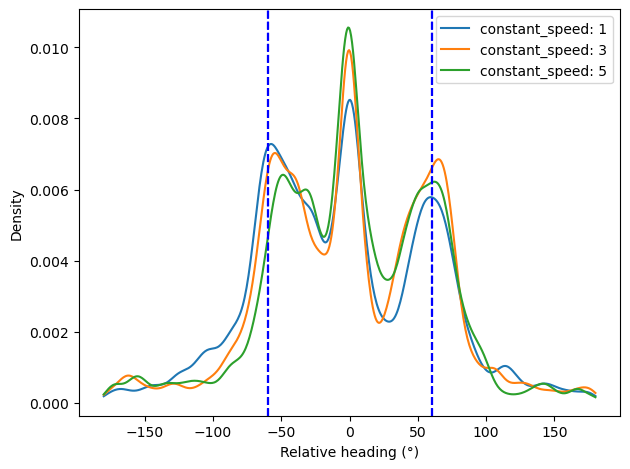

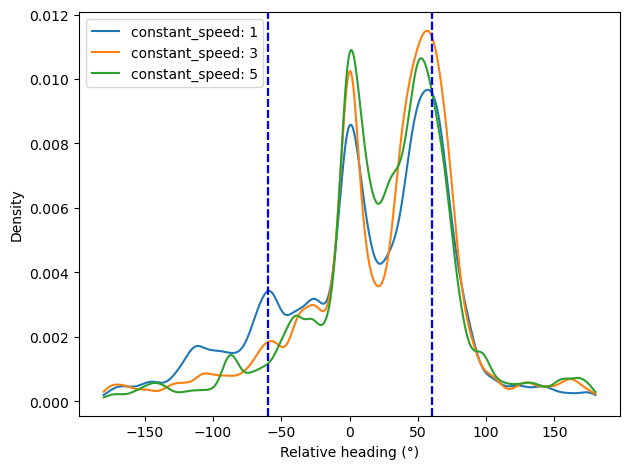

In [215]:
list_parameters = ["constant_speed"]

time_windows = generate_time_windows(critical_time2)
for version in angle_version:
    def group_select(df, list_parameters, version, time_windows, angle_bins, plt_hist=False, plt_kde=False):
        grouped = df.groupby(list_parameters)
        for groupvalues, group in grouped:
            label2 = ""
            for i in range(len(list_parameters)):
                if i > 0:
                    label2 += ", "
                label2 += f"{list_parameters[i]}: {groupvalues[i]}"
            plt_density(group, version, time_windows, angle_bins, plt_hist , plt_kde,label2=label2)
        plt.savefig(os.path.join(save_path, f'{list_parameters[i]}_{type}_{version}.png'), format='png', dpi=500)
        plt.show()
    group_select(df, list_parameters, version, time_windows, angle_bins, plt_hist=False, plt_kde=True)


#### 3.3 Trajectories

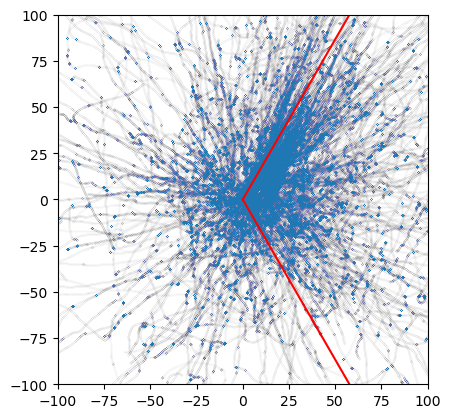

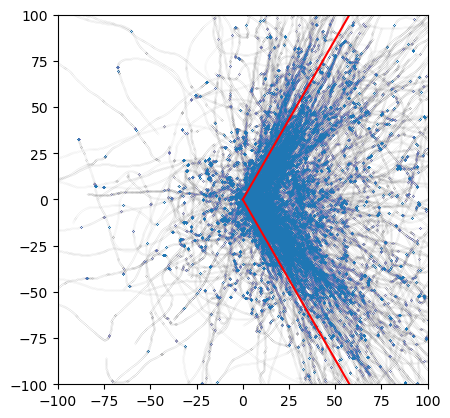

In [35]:
position_version = [position_version1, position_version2]
for version in position_version:
    mask = (df["ts"] >= 1000) & (df["ts"] < 6000)
    plt.scatter(-df.loc[mask, version[0]], -df.loc[mask, version[1]], s=0.02, alpha=0.01)

    # plt.scatter(df.loc[mask, 'X'], df.loc[mask, 'Y'], s=0.06, alpha=0.03)
    # plt.scatter(df['X_aligned'][0:9494], df['Y_aligned'][0:9494], s=0.06, alpha=0.03)
    # plt.scatter(df['X'], df['Y'], s=0.06, alpha=0.03)#, c=df['trial_id'], cmap='viridis')
    plt.xlim(-100, 100)
    plt.ylim(-100, 100)
    plt.gca().set_aspect('equal')

    X = np.linspace(0, 100, 500)

    # Calculate Y based on angle
    angle_deg = 60
    slope = np.tan(np.radians(angle_deg))

    Y = slope * X
    plt.plot(X, Y, color='red')
    plt.plot(X, -Y, color='red')
    # plt.savefig(os.path.join(save_path, f'locustvr_trajectories_{version[0]}.png'), format='png', dpi=300)
    plt.show()

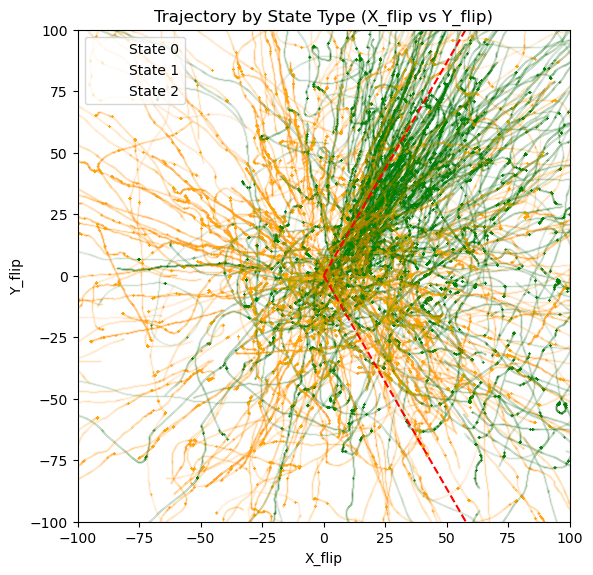

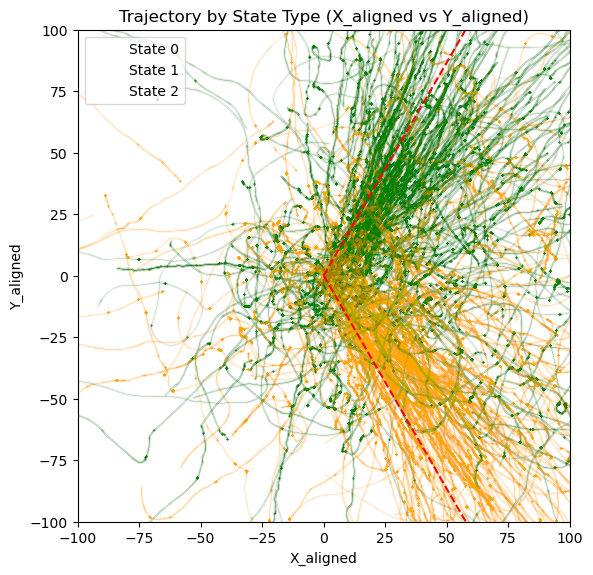

In [37]:
colors = {0: 'blue', 1: 'green', 2: 'orange'}  # assign colors per state_type

for version in position_version:
    plt.figure(figsize=(6, 6))

    mask = (df["ts"] >= 2000) & (df["ts"] < 6000)

    for state in [0, 1, 2]:
        state_mask = mask & (df["state_type"] == state)
        plt.scatter(
            -df.loc[state_mask, version[0]],
            -df.loc[state_mask, version[1]],
            s=0.1, alpha=0.03,
            label=f"State {state}",
            color=colors[state]
        )

    plt.xlim(-100, 100)
    plt.ylim(-100, 100)
    plt.gca().set_aspect('equal')

    # Add angle reference lines
    X = np.linspace(0, 100, 500)
    slope = np.tan(np.radians(60))
    plt.plot(X, slope * X, color='red', linestyle='--')
    plt.plot(X, -slope * X, color='red', linestyle='--')

    plt.legend(loc="upper left")
    plt.title(f"Trajectory by State Type ({version[0]} vs {version[1]})")
    plt.xlabel(version[0])
    plt.ylabel(version[1])
    plt.tight_layout()
    plt.show()

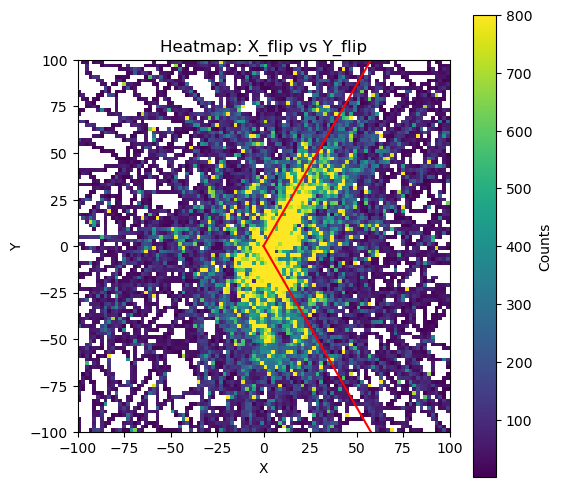

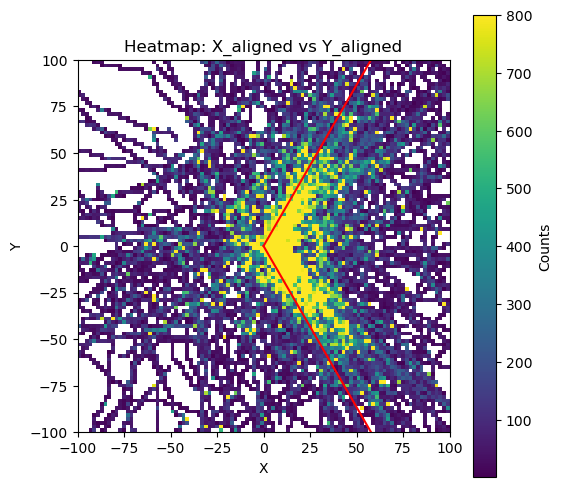

In [263]:
import matplotlib.pyplot as plt
import numpy as np

for version in position_version:
    mask = (df["ts"] >= 1000) & (df["ts"] < 6000)
    x = -df.loc[mask, version[0]]
    y = -df.loc[mask, version[1]]

    fig, ax = plt.subplots(figsize=(6, 6))

    # 2D Histogram Heatmap
    heatmap = ax.hist2d(
        x, y,
        bins=[400, 400],
        range=[[-400, 400], [-400, 400]],
        cmap='viridis',
        density=False,
        cmin=1,     # hide empty bins
        vmax=800    # optional: cap for contrast
    )
    fig.colorbar(heatmap[3], ax=ax).set_label("Counts")

    # ±60° guides
    X = np.linspace(0, 100, 500)
    angle_deg = 60
    slope = np.tan(np.radians(angle_deg))
    Y = slope * X
    ax.plot(X, Y, color='red')
    ax.plot(X, -Y, color='red')

    # Plot formatting
    ax.set_xlim(-100, 100)
    ax.set_ylim(-100, 100)
    ax.set_aspect('equal')
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_title(f"Heatmap: {version[0]} vs {version[1]}")

    # Uncomment if saving
    # plt.savefig(os.path.join(save_path, f'locustvr_trajectories_heatmap_{version[0]}.png'), format='png', dpi=300)
    plt.show()

['animal_id', 'trial_id', 'count_left', 'count_right', 'count_center', 'count_outside', 'fraction_left', 'fraction_right', 'fraction_center', 'fraction_outside', 'most_common_sector', 'mean_constant_speed', 'mean_constant_distance']


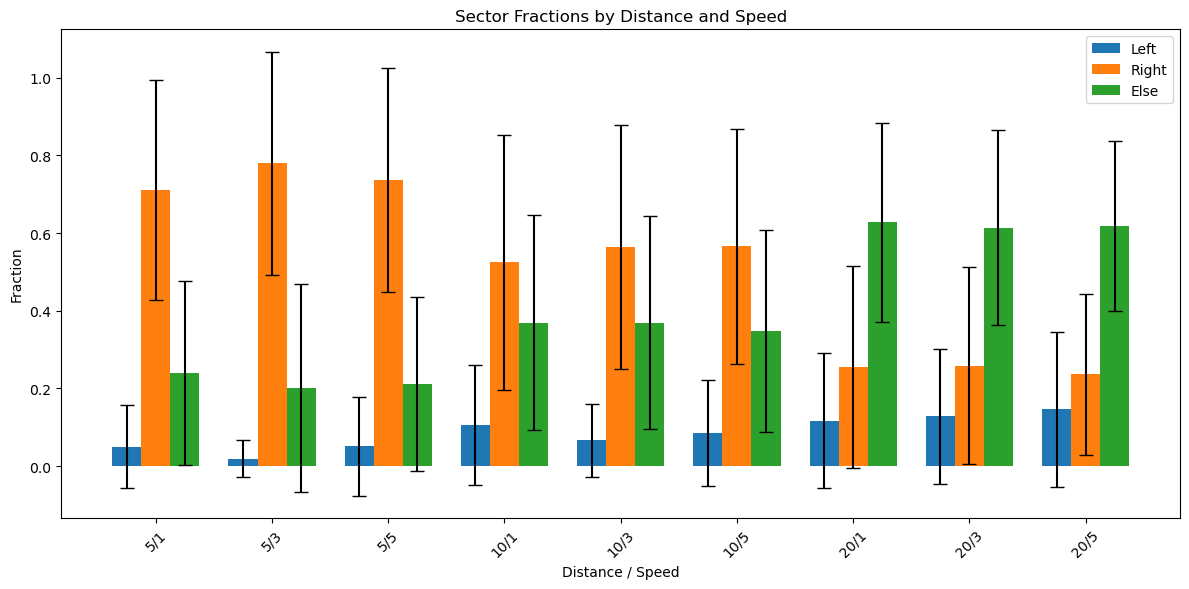

In [271]:

import pandas as pd

def compute_heading_sectors(df, angle_col='heading_rel_flip', trial_col='trial_id', animal_col='animal_id', t_col='ts', speed_col='constant_speed', distance_col='constant_distance'):
    df = df.copy()

    mu = [-60, 60]
    threshold = 30

    # Define sector boundaries
    left_bounds = (mu[0] - threshold, mu[0] + threshold)
    right_bounds = (mu[1] - threshold, mu[1] + threshold)
    center_bounds = (left_bounds[1], right_bounds[0])

    result_rows = []

    # Filter by ts window
    df = df[(df[t_col] >= 1000) & (df[t_col] < 6000)].copy()
    df['angle_deg'] = np.degrees(df[angle_col])

    for (animal, trial), group in df.groupby([animal_col, trial_col]):
        angles = group['angle_deg'].to_numpy()

        # Sector counts
        count_left = np.sum((angles >= left_bounds[0]) & (angles <= left_bounds[1]))
        count_right = np.sum((angles >= right_bounds[0]) & (angles <= right_bounds[1]))
        count_center = np.sum((angles > center_bounds[0]) & (angles < center_bounds[1]))
        count_outside = len(angles) - (count_left + count_right + count_center)

        # Determine dominant sector
        count_else = count_center + count_outside
        counts_comp = np.array([count_left, count_right, count_else])
        sectors_comp = ['left', 'right', 'else']
        most_common_sector = sectors_comp[np.argmax(counts_comp)]

        total = len(angles)

        # Summarize constant_speed and constant_distance (use mean here)
        mean_speed = group[speed_col].mean()
        mean_distance = group[distance_col].mean()

        result_rows.append({
            'animal_id': animal,
            'trial_id': trial,
            'count_left': count_left,
            'count_right': count_right,
            'count_center': count_center,
            'count_outside': count_outside,
            'fraction_left': count_left / total,
            'fraction_right': count_right / total,
            'fraction_center': count_center / total,
            'fraction_outside': count_outside / total,
            'most_common_sector': most_common_sector,
            'mean_constant_speed': round(mean_speed),
            'mean_constant_distance': round(mean_distance)
        })

    return pd.DataFrame(result_rows)

# Usage
results = compute_heading_sectors(df)
print(list(results))

# Initialize list with 4 sublists
import matplotlib.pyplot as plt
import numpy as np

# Add combined fraction
results["fraction_else"] = results["fraction_center"] + results["fraction_outside"]

# Bin or round speed/distance to clean groupings (optional)
results["speed_bin"] = results["mean_constant_speed"].round(2)
results["distance_bin"] = results["mean_constant_distance"].round(2)

# Group and compute mean and std for each sector
grouped = results.groupby(["distance_bin", "speed_bin"])

plot_data = []
labels = []

for (dist, speed), group in grouped:
    labels.append(f"{dist}/{speed}")
    plot_data.append({
        "mean_left": group["fraction_left"].mean(),
        "std_left": group["fraction_left"].std(),
        "mean_right": group["fraction_right"].mean(),
        "std_right": group["fraction_right"].std(),
        "mean_else": group["fraction_else"].mean(),
        "std_else": group["fraction_else"].std()
    })

# Convert to DataFrame for easier plotting
plot_df = pd.DataFrame(plot_data, index=labels)

# Bar plot with error bars
x = np.arange(len(plot_df))
width = 0.25

fig, ax = plt.subplots(figsize=(12, 6))

ax.bar(x - width, plot_df["mean_left"], width, yerr=plot_df["std_left"], label="Left", capsize=5)
ax.bar(x, plot_df["mean_right"], width, yerr=plot_df["std_right"], label="Right", capsize=5)
ax.bar(x + width, plot_df["mean_else"], width, yerr=plot_df["std_else"], label="Else", capsize=5)

ax.set_xticks(x)
ax.set_xticklabels(plot_df.index, rotation=45)
ax.set_ylabel("Fraction")
ax.set_xlabel("Distance / Speed")
ax.set_title("Sector Fractions by Distance and Speed")
ax.legend()
plt.tight_layout()
plt.show()

In [135]:
"""
Todo:
Clean up

Density direction trajectory (direct)
exclude if d_direct < threshold
plot directness vs angle direct
plot directness vs speed
plot speed vs angle direct
annotate left right with CS, CD

threshold decision
"""

'\nTodo:\nClean up\nImplement:\nMSD\nDirectness\nDensity direction trajectory (direct)\nexclude if d_direct < threshold\nplot directness vs angle direct\nplot directness vs speed\nplot speed vs angle direct\nannotate left right with CS, CD\nplot trajectories add direction to targets\n'